In [1]:
import os
import pandas as pd

import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.constraints import maxnorm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import pipeline

from scipy.stats import shapiro, normaltest, anderson
from statsmodels.stats.diagnostic import lilliefors

from joblib import load

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

In [2]:
X_treinamento = pd.read_json(r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\precipitacao\X_treinamento.json')
X_teste = pd.read_json      (r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\precipitacao\X_teste.json')
treino_json = pd.read_json  (r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\precipitacao\y_treinamento.json', typ='series')
teste_json = pd.read_json   (r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\precipitacao\y_teste.json', typ='series')

In [3]:
X_treinamento = X_treinamento.drop(['horario_experimento', 'mes_experimento', 'vazao_inicial', 'vazao_final', 'vazao_total'], axis=1)
X_teste = X_teste.drop(['horario_experimento', 'mes_experimento', 'vazao_inicial', 'vazao_final', 'vazao_total'], axis=1)

In [4]:
a = []
b = []

for i in range(treino_json.size):
    a.append(list(treino_json[i]))
    
for i in range(teste_json.size):
    b.append(list(teste_json[i]))

In [5]:
y_treinamento = np.array(a, dtype='float32')
y_teste = np.array(b, dtype='float32')

In [6]:
def build_model(
    optimizer,
    init_mode,
    activation,
    dropout_rate,
    weight_constraint,
    neurons,
    loss,
    regularizers
):
    model = models.Sequential()
    
    # layer 1
    model.add(
        layers.Dense(
            neurons,
            activation = activation,
            kernel_initializer=init_mode,
            kernel_constraint=maxnorm(weight_constraint),
            kernel_regularizer=regularizers,
            input_shape=[len(X_treinamento.keys())]
        )
    )
    model.add(layers.Dropout(dropout_rate))
    
    # layer 2
    model.add(layers.Dense(256))
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['mae', 'mse', keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [7]:
loaded_model = KerasRegressor(build_fn=build_model, verbose=1)

In [8]:
loaded_model.model = load_model(r'C:\Users\Everton\Documents\Mestrado\projeto-final\experimentos\precipitacao-experimento-1\resultados\Experimento-10\model-70-30-prec-1-10.h5')

In [9]:
scaler = load(r'C:\Users\Everton\Documents\Mestrado\projeto-final\experimentos\precipitacao-experimento-1\resultados\Experimento-10\scaler-70-30-prec-1-10.joblib')

In [10]:
loaded_steps = [('scaler', scaler), 
         ('estimator', loaded_model)]

In [11]:
loaded_pipe = pipeline.Pipeline(loaded_steps)

In [12]:
plm = loaded_pipe.predict(X_teste)

1/1 [==============================] - 0s 7ms/step


In [13]:
expectedWlm = []
for i in range(y_teste.shape[0]):
    dfE = pd.DataFrame(
        y_teste[i].reshape(16,16), 
        columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', 
                 '9', '10', '11', '12', '13', '14', '15'])
    w = dfE.values.sum()
    expectedWlm.append(w)

In [14]:
predictedWlm = []
for i in range(plm.shape[0]):
    dfP = pd.DataFrame(
        plm[i].reshape(16,16), 
        columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', 
                 '9', '10', '11', '12', '13', '14', '15'])
    for i in range(16):
        dfP.loc[dfP[str(i)] < 0, str(i)] = 0
    w = dfP.values.sum()
    predictedWlm.append(w)

In [15]:
for prediction, real in zip(predictedWlm, expectedWlm):
    print("Prediction: %f - Real: %f - Error: %f" % (prediction, real, real - prediction))

Prediction: 452.262573 - Real: 430.600006 - Error: -21.662567
Prediction: 482.395508 - Real: 537.449951 - Error: 55.054443
Prediction: 1099.031982 - Real: 1034.400146 - Error: -64.631836
Prediction: 903.511353 - Real: 898.500000 - Error: -5.011353
Prediction: 1104.942871 - Real: 1120.899902 - Error: 15.957031
Prediction: 524.289673 - Real: 418.950012 - Error: -105.339661
Prediction: 1285.309082 - Real: 1351.099976 - Error: 65.790894
Prediction: 662.336670 - Real: 658.700073 - Error: -3.636597
Prediction: 967.872742 - Real: 1094.699951 - Error: 126.827209
Prediction: 834.149658 - Real: 1001.900024 - Error: 167.750366
Prediction: 738.772705 - Real: 869.799927 - Error: 131.027222
Prediction: 572.857056 - Real: 548.949951 - Error: -23.907104
Prediction: 1059.429199 - Real: 1089.699951 - Error: 30.270752
Prediction: 698.135742 - Real: 736.449951 - Error: 38.314209
Prediction: 774.848511 - Real: 692.699951 - Error: -82.148560
Prediction: 1131.561035 - Real: 1052.800049 - Error: -78.760986
Pr

In [16]:
print("{0:0.5f}".format(mean_absolute_error(predictedWlm, expectedWlm)))

56.61879


In [17]:
print("{0:0.5f}".format(mean_squared_error(predictedWlm, expectedWlm)))

5274.44678


In [18]:
print("{0:0.5f}".format(mean_squared_error(predictedWlm, expectedWlm, squared=False)))

72.62539


In [19]:
print(r2_score(predictedWlm, expectedWlm))

0.8985235081367501


In [20]:
hist = pd.read_json(r'C:\Users\Everton\Documents\Mestrado\projeto-final\experimentos\precipitacao-experimento-1\resultados\Experimento-10\prec-1-10-history')

In [21]:
sns.set_theme()

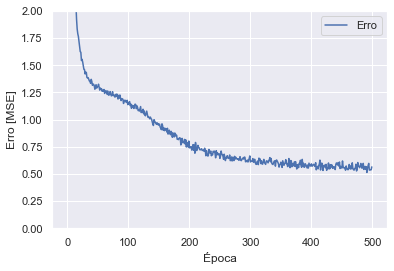

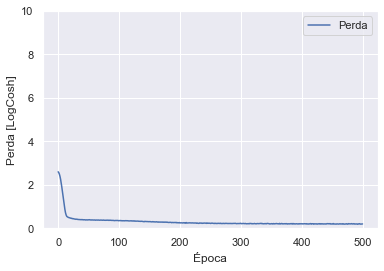

In [23]:
def plot_history(hist):
#     hist = pd.DataFrame(grid_result.best_estimator_['estimator'].model.history.history)
    hist.reset_index(inplace=True)
    hist = hist.rename(columns = {'index':'epoch'})

    plt.figure()
    plt.xlabel('Época')
    plt.ylabel('Erro [MSE]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Erro')
    plt.ylim([0,2])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Época')
    plt.ylabel('Perda [LogCosh]')
    plt.plot(hist['epoch'], hist['loss'],
           label='Perda')
    plt.ylim([0,10])
    plt.legend()
    plt.show()


plot_history(hist)

In [24]:
error = pd.Series(np.array(expectedWlm) - np.array(predictedWlm))

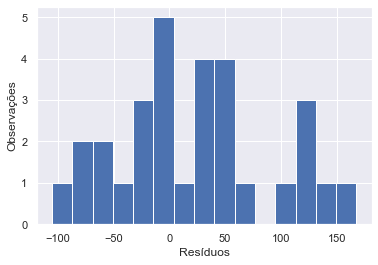

In [25]:
plt.hist(error, bins = 15)
plt.xlabel("Resíduos")
_ = plt.ylabel("Observações")

In [26]:
resultados = pd.DataFrame({'Valores Preditos':predictedWlm, 'Resíduos':error})

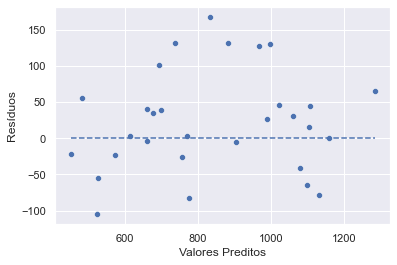

In [28]:
sns.scatterplot(data=resultados, x="Valores Preditos", y="Resíduos")
ax = sns.lineplot(x=resultados['Valores Preditos'],y=0, dashes=[(2, 2), (2, 2)])
ax.lines[0].set_linestyle("--")
plt.show()

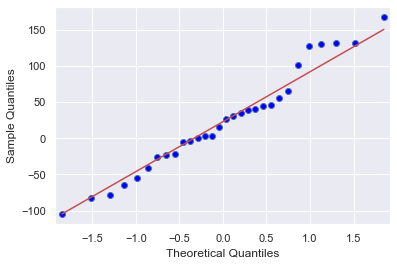

In [29]:
qqplot(error, line='s')
plt.show()

In [30]:
sp = shapiro(error)
sp

ShapiroResult(statistic=0.9686387777328491, pvalue=0.5026339888572693)

In [31]:
nt = normaltest(error)
nt

NormaltestResult(statistic=0.6681964359407312, pvalue=0.7159834563317353)

In [32]:
lf = lilliefors(error)
lf

(0.1079299469405498, 0.48801838980323076)

In [33]:
result = anderson(error)
print('Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.342
15.000: 0.521, data looks normal (fail to reject H0)
10.000: 0.593, data looks normal (fail to reject H0)
5.000: 0.712, data looks normal (fail to reject H0)
2.500: 0.830, data looks normal (fail to reject H0)
1.000: 0.988, data looks normal (fail to reject H0)


In [35]:
result

AndersonResult(statistic=0.34197669384519713, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))